On remarque qu'une partie des transferts sont invisibles topologiquement : étant donné que les arbres considérés par ALE utilisent une différence de topologie entre l'arbre d'espèces et l'arbre de gènes, tout transfert d'une espèce vers son espèce soeur, ou 

On essaye de calculer la proportion de transferts provenant d'une espèce qui sont absorbés par une espèce telle qu'il n'y aura pas de changement de topologie.

In [ ]:
from ete3 import Tree

def give_names(tree):
    index = 0
    for node in tree.traverse():
        if not node.is_leaf():
            node.name = str(index)
            index += 1
    return tree

def give_depth(tree):
    tree.dist = 0
    tree.depth = 0
    for node in tree.traverse(strategy="preorder"):
        if not node.is_root():
            node.depth = node.up.depth + node.dist
    return tree

def subdivision_times(tree):
    times = []
    for node in tree.traverse():
        if not node.is_leaf():
            times.append(node.depth)
    times.append(tree.get_leaves()[0].depth)
    return times    


def compute_intervals(times):
    list_intervals = []
    times = sorted(set(times))
    for i in range(len(times) - 1):
        start = times[i]
        end = times[i + 1]
        list_intervals.append((start, end))
    return list_intervals

def is_alive_on_interval(start, end, node):
    # we look at the average of the interval, and see if it is greater that the starting time 
    # and smaller than the ending time
    return node.depth-node.dist <= (start + end) / 2 <= node.depth
def compute_existence_vector(tree, intervals):
    dict_alive = {node.name: [] for node in tree.traverse()}
    for node in tree.traverse():
        for interval in intervals:
            if is_alive_on_interval(interval[0], interval[1], node):
                dict_alive[node.name].append(1)
            else:
                dict_alive[node.name].append(0)
    return dict_alive

def compute_LTT(tree, intervals, dict_alive):
    LTT = []
    for interval in intervals:
        count = 0
        for node in tree.traverse():
            if dict_alive[node.name][intervals.index(interval)]:
                count += 1
        LTT.append(count)
    return LTT

In [ ]:
give_names(tree)
give_depth(tree)
times = subdivision_times(tree)
intervals = compute_intervals(times)
existence_vector = compute_existence_vector(tree, intervals)
LTT = compute_LTT(tree, intervals, existence_vector)

In [ ]:
# plot LTT against time, using the time intervals
import matplotlib.pyplot as plt
x = [sum(interval)/2 for interval in intervals]
plt.plot(x, LTT)
plt.xlabel("Time")
plt.ylabel("Lineages")
plt.title("Lineages Through Time")
plt.show()

In [ ]:
from dendropy.model.birthdeath import birth_death_tree as bdt
from ete3 import Tree
tree = bdt(birth_rate=1, death_rate=0, num_extant_tips=10)
tree.write(path="tree.nwk", schema="newick", suppress_rooting=True)
tree = Tree("tree.nwk", format=1)

On a maintenant un dictionnaire contenant le nombre d'espèces présentes sur chaque intervalle. Cela va nous permettre de calculer le nombre de transferts invisibles.

Pour calculer cela, il faut choisir un clade ghost, puis calculer les receveurs de transferts pour lesquels un transfert n'aurait aucun effet.

On considère seulement les transferts uniques, sans considérer les compositions de transferts. On regardera les compositions avec 2 transferts plus tard, et on verra si on peut généraliser.

Quand on dessine un quartet correspondant à un arbre non raciné, on remarque les choses suivantes :
1. Les transferts qui sont invisibles sont les transferts qui vont vers la branche du milieu, ou vers la branche C1, ou la branche C2, ou la branche A ou B
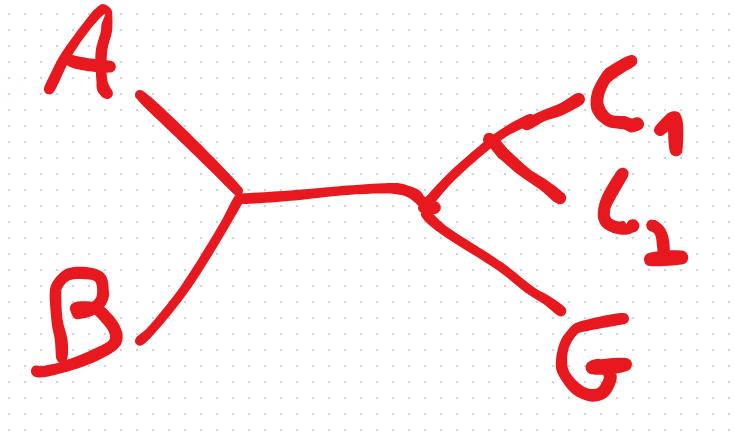

In [ ]:
tree_1 = Tree("C1_tr.nwk", format=1)
tree_2 = Tree("removed_no_spr.nwk", format=1)

In [ ]:
tree_1.compare(tree_2, unrooted=True)

En principe, on pourrait regarder explicitement les noeuds pour lesquels les transferts ne changent pas la topologie, mais il est plus pratique de réaliser explicitement les SPR, et de vérifier si les arbres obtenus sont à une distance RF == 0 de l'arbre sans transfert, après avoir enlevé le clade ghost.

In [ ]:
def divide_into_quartets(tree, G_node):
    """Divide the tree into a quartet of trees, with G_node as the root of the quartet."""
    # G_node always has a parent since it is a ghost clade, branching somewhere.
    if G_node.up.up is not None:
        invisible_nodes = []
        GC_node = G_node.up
        left_node = GC_node.get_children()[0]
        right_node = GC_node.get_children()[1]
        if left_node == G_node:
            C_node = right_node
        else:
            C_node = left_node
        if not C_node.is_leaf():
            C_1_node = C_node.get_children()[0]
            C_2_node = C_node.get_children()[1]
        GCB_node = GC_node.up
        left_node = GCB_node.get_children()[0]
        right_node = GCB_node.get_children()[1]
        if left_node == GC_node:
            B_node = right_node
        else:
            B_node = left_node
            

In [ ]:
def SPR(tree, donor, receiver):
    # First remove the receiver from the tree
    receiver = tree.search_nodes(name=receiver)[0]
    receiver.detach()
    # detach the donor
    donor = tree.search_nodes(name=donor)[0]
    donor.detach()
    # attach the receiver to the donor
    donor.add_child(receiver)
    # attach the donor to the receiver's

In [ ]:
from ete3 import Tree
tree = Tree("tree.nwk", format=1)

In [ ]:
index = 0
for node in tree.traverse():
    if not node.is_leaf():
        node.name = str(index)
        index += 1
tree.write(outfile="tree.nwk", format=1, format_root_node=True)


In [ ]:
tree

In [ ]:
tree

In [ ]:
tree = Tree("tree.nwk", format=1)
print([node.name for node in tree.traverse()])

In [ ]:
def change_tree(tree, node_1, node_2):
    # First, detach the receiver from the tree. To do that, we remove its parent.
    node_2_sister = node_2.get_sisters()[0]
    node_2_sister.detach()
    #print("after detaching node_2_sister:", tree)
    node_2.up.up.add_child(node_2_sister)
    #print("after adding node_2_sister:", tree)
    node_2_up = node_2.up
    node_2_up.detach()
    #print("after detaching node_2_up:", tree)
    node_1_parent = node_1.up
    node_1_parent.add_child(node_2, dist=node_1_parent.dist)
    #print("after adding node_2:", tree)
    node_2.add_child(node_1, dist=node_2.dist)
    #print("after adding node_1:", tree)
    return tree

In [ ]:
tree = Tree("tree.nwk", format=1)
new_tree = change_tree(tree, tree&"6", tree&"T6")

In [ ]:
from copy import deepcopy
new_tree = change_tree(deepcopy(tree), tree&"6", tree&"5")


In [ ]:
tree = Tree("tree.nwk", format=1)


In [ ]:
print(tree)

In [ ]:
print(new_tree)

In [ ]:
new_tree.write(outfile="weird_tree.nwk", format=1, format_root_node=True)

In [ ]:
tree = Tree("tree.nwk", format=1)
print(tree)
copied_tree = tree.copy()
change_tree(copied_tree, "6", "5", 0)
print(copied_tree)

In [ ]:
copied_tree.compare(tree, unrooted=True)["rf"]

In [ ]:
SPR_path = "/home/enzo/Documents/git/ghost_experiments/SPR/target/debug/SPR"

In [ ]:
import subprocess
bin_path = "/home/enzo/Documents/git/ghost_experiments/SPR/target/release/SPR"
tree_path = "/home/enzo/Documents/git/ghost_experiments/tree.nwk"
species_1 = "6"
species_2 = "5"
output_tree_path = "/home/enzo/Documents/git/ghost_experiments/tree_out.nwk"
command = [bin_path, tree_path, species_1, species_2, output_tree_path]

result = subprocess.run(command, capture_output=True, text=True)
if result.returncode == 0:
    print("Command executed successfully.")
    print("Output:", result.stdout)
else:
    print("Error executing command.")
    print("Error message:", result.stderr)

In [ ]:
from ete3 import Tree
import subprocess

def make_hgt_with_script(tree_path, species_1, species_2, output_path):
    """
    Calls the external script to perform HGT on the tree.
    
    Parameters:
        tree_path     : Path to the input tree file.
        species_1     : Name of the donor species.
        species_2     : Name of the recipient species.
        output_path   : Path to save the output tree file.
    """
    command = ["/home/enzo/Documents/git/ghost_experiments/SPR/target/release/SPR", tree_path, species_1, species_2, output_path]
    result = subprocess.run(command, capture_output=True, text=True)
    if result.returncode == 0:
        print("Command executed successfully.")
        print("Output:", result.stdout)
    else:
        print("Error executing command.")
        print("Error message:", result.stderr)
    # open the output file and return the tree
    tree = Tree(output_path, format=1)
    return tree


In [ ]:
out_tree = make_hgt_with_script("tree.nwk", "3", "2", "tree_out.nwk")

In [ ]:
def find_pairs_without_change(tree_path, species_1):
    tree = Tree(tree_path, format=1)
    list_no_change = []
    list_nodes_to_check = []
    for node in tree.traverse():
        if not node.is_root() and not species_1 in [leaf.name for leaf in node.get_children()]:
            list_nodes_to_check.append(node)
    for node in list_nodes_to_check:
        try:
            print("processing node", node.name)
            node_name = node.name
            if not node_name == species_1:
                make_hgt_with_script(tree_path, species_1, node_name, "/home/enzo/Documents/git/ghost_experiments/tree_out.nwk")
                # check if the new tree is the same as the original tree
                new_tree = Tree("/home/enzo/Documents/git/ghost_experiments/tree_out.nwk", format=1)
                if tree.compare(new_tree, unrooted=True)["rf"] == 0:
                    list_no_change.append(node_name)
        except Exception as e:
            print(f"Error processing node {node.name}: {e}")
    return list_no_change

In [ ]:
(tree&"1").get_children()

In [ ]:
tree.get_children()

toujours problème : quand on fait un transfert, il peut ne plus y avoir de racine

In [ ]:
tree_2 = make_hgt_with_script("tree.nwk", "3", "2", "tree_out.nwk")

In [ ]:
find_pairs_without_change("/home/enzo/Documents/git/ghost_experiments/tree.nwk", "3")

In [ ]:
# import deepcopy
from copy import deepcopy

In [ ]:
def compute_unchanged(tree, donor_node):
    unchanged = []
    for node in tree.traverse():
        if node.name != donor_node.name and not node.is_root():
            # copy the tree, and compute a hgt from the donor node to the node
            tree_copy = deepcopy(tree)
            tree_copy = change_tree(tree_copy, donor_node.name, node.name, 0)
            # compare the two trees
            if tree_copy.compare(tree, unrooted=True):
                unchanged.append(node.name)
    return unchanged

In [ ]:
compute_contemporaneity_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/compute_contemporaneity"
compute_spr_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/make_spr"

In [ ]:
import subprocess
def compute_spr(tree_path, donor, receiver, output_path):
    command = [compute_spr_path, tree_path, donor, receiver, output_path]
    result = subprocess.run(command, capture_output=True, text=True)
    if result.returncode == 0:
        print("Command executed successfully.")
        print("Output:", result.stdout)
    else:
        print("Error executing command.")
        print("Error message:", result.stderr)
    return result.stdout

In [ ]:
import os
spr_path = "spr_trees"
os.makedirs(spr_path, exist_ok=True)

In [ ]:
compute_spr("tree.nwk", "3", "2", os.path.join(spr_path, "3_2.nwk"))

In [ ]:
from ete3 import Tree
tree = Tree("tree.nwk", format=1)

In [ ]:
leaf = tree.get_leaves()[0]

In [ ]:
leaf.get_ancestors()

est-ce qu'on doit inclure la racine, ou des transferts vers des descendants ou des ancêtres, étant donné que ALE peut faire ces SPR ?

In [ ]:
def compute_all_sprs_from_donor(tree_path, donor):
    tree = Tree(tree_path, format=1)
    sprs = {}
    donor_node = tree.search_nodes(name=donor)[0]
    donor_descendants = [n.name for n in donor_node.get_descendants()]
    donor_ancestors = [n.name for n in donor_node.get_ancestors()]
    possible_receivers = [
        n.name for n in tree.traverse()
        if n.name != donor and not n.is_root()
        and n.name not in donor_descendants
        and n.name not in donor_ancestors
    ]
    for receiver in possible_receivers:
        this_spr_path = os.path.join(spr_path, f"{donor}_{receiver}.nwk")
        compute_spr(tree_path, donor, receiver, this_spr_path)
        sprs[(donor, receiver)] = Tree(this_spr_path, format=1)
    return sprs

def compute_all_sprs(tree_path):
    tree = Tree(tree_path, format=1)
    possible_donors = [n.name for n in tree.traverse() if not n.is_root()]
    sprs = {}
    for donor in possible_donors:
        donor_sprs = compute_all_sprs_from_donor(tree_path, donor)
        sprs.update(donor_sprs)  # donor_sprs already uses (donor, receiver) as keys
    return sprs

In [ ]:
d = compute_all_sprs_from_donor("tree.nwk", "3")

In [ ]:
d = compute_all_sprs("tree.nwk")

In [ ]:
tree.robinson_foulds()

In [ ]:
from ete3 import Tree
from collections import defaultdict


compute_contemporaneity_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/compute_contemporaneity"
compute_spr_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/make_spr"
import subprocess
def compute_spr(tree_path, donor, receiver, output_path):
    command = [compute_spr_path, tree_path, donor, receiver, output_path]
    result = subprocess.run(command, capture_output=True, text=True)
    if result.returncode == 0:
        print("Command executed successfully.")
        print("Output:", result.stdout)
    else:
        print("Error executing command.")
        print("Error message:", result.stderr)
    return result.stdout
def compute_all_sprs_from_donor(tree_path, donor):
    tree = Tree(tree_path, format=1)
    sprs = {}
    donor_node = tree.search_nodes(name=donor)[0]
    donor_descendants = [n.name for n in donor_node.get_descendants()]
    donor_ancestors = [n.name for n in donor_node.get_ancestors()]
    possible_receivers = [
        n.name for n in tree.traverse()
        if n.name != donor and not n.is_root()
        and n.name not in donor_descendants
        and n.name not in donor_ancestors
    ]
    for receiver in possible_receivers:
        this_spr_path = os.path.join(spr_path, f"{donor}_{receiver}.nwk")
        compute_spr(tree_path, donor, receiver, this_spr_path)
        sprs[(donor, receiver)] = Tree(this_spr_path, format=1)
    return sprs

def compute_all_sprs(tree_path):
    tree = Tree(tree_path, format=1)
    possible_donors = [n.name for n in tree.traverse() if not n.is_root()]
    sprs = {}
    for donor in possible_donors:
        donor_sprs = compute_all_sprs_from_donor(tree_path, donor)
        sprs.update(donor_sprs)  # donor_sprs already uses (donor, receiver) as keys
    return sprs

def group_trees_by_topology(pair_to_tree):
    grouped = {}  # Will store: tree string -> representative Tree object
    result = defaultdict(list)  # Output: representative Tree object -> list of pairs

    for pair, tree in pair_to_tree.items():
        # Work with a copy and unroot it
        t1 = tree.copy()
        t1.unroot()

        found_group = False
        for rep_tree_str, rep_tree in grouped.items():
            # Compare unrooted trees using Robinson-Foulds (RF) distance
            rf = t1.robinson_foulds(rep_tree, unrooted_trees=True)[0]
            if rf == 0:
                result[rep_tree].append(pair)
                found_group = True
                break

        if not found_group:
            # New unique topology found
            grouped[t1.write(format=9)] = t1
            result[t1] = [pair]

    return result

In [ ]:
group_trees_by_topology(d)

Je pensais initialement calculer seulement les transferts qui laissent invariante la topologie initiale

In [ ]:
import pandas as pd
from ete3 import Tree
from collections import defaultdict


compute_contemporaneity_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/compute_contemporaneity"
compute_spr_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/make_spr"
import subprocess
def compute_spr(tree_path, donor, receiver, output_path):
    command = [compute_spr_path, tree_path, donor, receiver, output_path]
    result = subprocess.run(command, capture_output=True, text=True)
    if result.returncode == 0:
        print("Command executed successfully.")
        print("Output:", result.stdout)
    else:
        print("Error executing command.")
        print("Error message:", result.stderr)
    return result.stdout
def compute_all_sprs_from_donor(tree_path, donor):
    tree = Tree(tree_path, format=1)
    sprs = {}
    donor_node = tree.search_nodes(name=donor)[0]
    donor_descendants = [n.name for n in donor_node.get_descendants()]
    donor_ancestors = [n.name for n in donor_node.get_ancestors()]
    possible_receivers = [
        n.name for n in tree.traverse()
        if n.name != donor and not n.is_root()
        and n.name not in donor_descendants
        and n.name not in donor_ancestors
    ]
    for receiver in possible_receivers:
        this_spr_path = os.path.join(spr_path, f"{donor}_{receiver}.nwk")
        compute_spr(tree_path, donor, receiver, this_spr_path)
        sprs[(donor, receiver)] = Tree(this_spr_path, format=1)
    return sprs

def compute_all_sprs(tree_path):
    tree = Tree(tree_path, format=1)
    possible_donors = [n.name for n in tree.traverse() if not n.is_root()]
    sprs = {}
    for donor in possible_donors:
        donor_sprs = compute_all_sprs_from_donor(tree_path, donor)
        sprs.update(donor_sprs)  # donor_sprs already uses (donor, receiver) as keys
    return sprs

def group_trees_by_topology(pair_to_tree):
    grouped = {}  # Will store: tree string -> representative Tree object
    result = defaultdict(list)  # Output: representative Tree object -> list of pairs

    for pair, tree in pair_to_tree.items():
        # Work with a copy and unroot it
        t1 = tree.copy()
        t1.unroot()

        found_group = False
        for rep_tree_str, rep_tree in grouped.items():
            # Compare unrooted trees using Robinson-Foulds (RF) distance
            rf = t1.robinson_foulds(rep_tree, unrooted_trees=True)[0]
            if rf == 0:
                result[rep_tree].append(pair)
                found_group = True
                break

        if not found_group:
            # New unique topology found
            grouped[t1.write(format=9)] = t1
            result[t1] = [pair]

    return result
def compute_contemporaneity(tree_path):
    output_path = "contemporaneity.csv"
    command = [compute_contemporaneity_path, tree_path, output_path]
    subprocess.run(command, capture_output=True, text=True)
    # read the output file
    # IntervalStart,IntervalEnd,IntervalLength,SpeciesAlive
    df = pd.read_csv(output_path, dtype={"IntervalStart": float, "IntervalEnd": float, "IntervalLength": float, "SpeciesAlive": str})
    return df

contemp = compute_contemporaneity("tree.nwk")
def compute_transfers_expectancy(contemporaneity_df):
    pairs_transfers = defaultdict(float)

    for index, row in contemporaneity_df.iterrows():
        # look at species alive
        species_alive = row["SpeciesAlive"].split(";")
        for i in range(len(species_alive)):
            for j in range(len(species_alive)):
                if i != j:
                    pairs_transfers[(species_alive[i], species_alive[j])] += row["IntervalLength"] / (len(species_alive) - 1)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(
        [(k[0], k[1], v) for k, v in pairs_transfers.items()],
        columns=["Species1", "Species2", "Value"]
    )
    return df

In [ ]:
def compute_transfers_expectancy(contemporaneity_df):
    pairs_transfers = defaultdict(float)

    for index, row in contemporaneity_df.iterrows():
        # look at species alive
        species_alive = row["SpeciesAlive"].split(";")
        for i in range(len(species_alive)):
            for j in range(len(species_alive)):
                if i != j:
                    pairs_transfers[(species_alive[i], species_alive[j])] += row["IntervalLength"] / (len(species_alive) - 1)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(
        [(k[0], k[1], v) for k, v in pairs_transfers.items()],
        columns=["Species1", "Species2", "Value"]
    )
    return df

In [ ]:
contemp

On peut maintenant calculer l'espérance du nombre de transferts entre n'importe quelle paire d'espèces.

In [ ]:
compute_transfers_expectancy(contemp)

Now we can add a new column saying whether a transfer from a given species to another species is invisible. This allows us to test how many transfers coming from the ghost group will be invisible: look at the topology of the sampled tree after an SPR from the induced donor to the given receiver, and compute whether it leaves a trace or not. Then sum over ghost species where transfers are visible, over the sum over all ghost species transfers to species outside the ghost clade.

In [ ]:
print(tree)

In [ ]:
(tree&'5').detach()

In [ ]:
print(tree)

In [ ]:
tree.write(outfile="pruned_tree.nwk", format=1, format_root_node=True)

In [ ]:
import pandas as pd
from ete3 import Tree
from collections import defaultdict


compute_contemporaneity_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/compute_contemporaneity"
compute_spr_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/make_spr"
import subprocess
def compute_spr(tree_path, donor, receiver, output_path):
    command = [compute_spr_path, tree_path, donor, receiver, output_path]
    result = subprocess.run(command, capture_output=True, text=True)
    if result.returncode == 0:
        print("Command executed successfully.")
        print("Output:", result.stdout)
    else:
        print("Error executing command.")
        print("Error message:", result.stderr)
    return result.stdout
def compute_all_sprs_from_donor(tree_path, donor):
    tree = Tree(tree_path, format=1)
    sprs = {}
    donor_node = tree.search_nodes(name=donor)[0]
    donor_descendants = [n.name for n in donor_node.get_descendants()]
    donor_ancestors = [n.name for n in donor_node.get_ancestors()]
    possible_receivers = [
        n.name for n in tree.traverse()
        if n.name != donor and not n.is_root()
        and n.name not in donor_descendants
        and n.name not in donor_ancestors
    ]
    for receiver in possible_receivers:
        this_spr_path = os.path.join(spr_path, f"{donor}_{receiver}.nwk")
        compute_spr(tree_path, donor, receiver, this_spr_path)
        sprs[(donor, receiver)] = Tree(this_spr_path, format=1)
    return sprs

def compute_all_sprs(tree_path):
    tree = Tree(tree_path, format=1)
    possible_donors = [n.name for n in tree.traverse() if not n.is_root()]
    sprs = {}
    for donor in possible_donors:
        donor_sprs = compute_all_sprs_from_donor(tree_path, donor)
        sprs.update(donor_sprs)  # donor_sprs already uses (donor, receiver) as keys
    return sprs

def group_trees_by_topology(pair_to_tree):
    grouped = {}  # Will store: tree string -> representative Tree object
    result = defaultdict(list)  # Output: representative Tree object -> list of pairs

    for pair, tree in pair_to_tree.items():
        # Work with a copy and unroot it
        t1 = tree.copy()
        t1.unroot()

        found_group = False
        for rep_tree_str, rep_tree in grouped.items():
            # Compare unrooted trees using Robinson-Foulds (RF) distance
            rf = t1.robinson_foulds(rep_tree, unrooted_trees=True)[0]
            if rf == 0:
                result[rep_tree].append(pair)
                found_group = True
                break

        if not found_group:
            # New unique topology found
            grouped[t1.write(format=9)] = t1
            result[t1] = [pair]

    return result
def compute_contemporaneity(tree_path):
    output_path = "contemporaneity.csv"
    command = [compute_contemporaneity_path, tree_path, output_path]
    subprocess.run(command, capture_output=True, text=True)
    # read the output file
    # IntervalStart,IntervalEnd,IntervalLength,SpeciesAlive
    df = pd.read_csv(output_path, dtype={"IntervalStart": float, "IntervalEnd": float, "IntervalLength": float, "SpeciesAlive": str})
    return df

contemp = compute_contemporaneity("tree.nwk")
def compute_transfers_expectancy(contemporaneity_df):
    pairs_transfers = defaultdict(float)

    for index, row in contemporaneity_df.iterrows():
        # look at species alive
        species_alive = row["SpeciesAlive"].split(";")
        for i in range(len(species_alive)):
            for j in range(len(species_alive)):
                if i != j:
                    pairs_transfers[(species_alive[i], species_alive[j])] += row["IntervalLength"] / (len(species_alive) - 1)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(
        [(k[0], k[1], v) for k, v in pairs_transfers.items()],
        columns=["Species1", "Species2", "Value"]
    )
    return df
def join_branch(node, bprops=None):
    """Substitute node for its only child."""
    assert len(node.children) == 1, 'Cannot join branch with multiple children'

    child = node.children[0]

    if hasattr(node, "dist"):
        child.dist = (child.dist or 0) + node.dist

    parent = node.up
    idx = parent.children.index(node)
    parent.children[idx] = child
    child.up = parent



In [ ]:
def join_branch(node, bprops=None):
    """Substitute node for its only child."""
    assert len(node.children) == 1, 'Cannot join branch with multiple children'

    child = node.children[0]

    if hasattr(node, "dist"):
        child.dist = (child.dist or 0) + node.dist

    parent = node.up
    idx = parent.children.index(node)
    parent.children[idx] = child
    child.up = parent



In [ ]:
for node in tree.traverse():
    if len(node.children) == 1:
        join_branch(node)

In [ ]:
import pandas as pd
from ete3 import Tree
from collections import defaultdict
import subprocess

compute_contemporaneity_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/compute_contemporaneity"
compute_spr_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/make_spr"


def compute_spr(tree_path, donor, receiver, output_path):
    command = [compute_spr_path, tree_path, donor, receiver, output_path]
    result = subprocess.run(command, capture_output=True, text=True)
    if result.returncode == 0:
        print("Command executed successfully.")
        print("Output:", result.stdout)
    else:
        print("Error executing command.")
        print("Error message:", result.stderr)
    return result.stdout

def compute_all_sprs_from_donor(tree_path, donor, spr_path="spr_trees"):
    tree = Tree(tree_path, format=1)
    sprs = {}
    donor_node = tree.search_nodes(name=donor)[0]
    donor_descendants = [n.name for n in donor_node.get_descendants()]
    donor_ancestors = [n.name for n in donor_node.get_ancestors()]
    possible_receivers = [
        n.name for n in tree.traverse()
        if n.name != donor and not n.is_root()
        and n.name not in donor_descendants
        and n.name not in donor_ancestors
    ]
    for receiver in possible_receivers:
        this_spr_path = os.path.join(spr_path, f"{donor}_{receiver}.nwk")
        compute_spr(tree_path, donor, receiver, this_spr_path)
        sprs[(donor, receiver)] = Tree(this_spr_path, format=1)
    return sprs

def compute_all_sprs(tree_path):
    tree = Tree(tree_path, format=1)
    possible_donors = [n.name for n in tree.traverse() if not n.is_root()]
    sprs = {}
    for donor in possible_donors:
        donor_sprs = compute_all_sprs_from_donor(tree_path, donor)
        sprs.update(donor_sprs)  # donor_sprs already uses (donor, receiver) as keys
    return sprs

def group_trees_by_topology(pair_to_tree):
    grouped = {}  # Will store: tree string -> representative Tree object
    result = defaultdict(list)  # Output: representative Tree object -> list of pairs

    for pair, tree in pair_to_tree.items():
        # Work with a copy and unroot it
        t1 = tree.copy()
        t1.unroot()

        found_group = False
        for rep_tree_str, rep_tree in grouped.items():
            # Compare unrooted trees using Robinson-Foulds (RF) distance
            rf = t1.robinson_foulds(rep_tree, unrooted_trees=True)[0]
            if rf == 0:
                result[rep_tree].append(pair)
                found_group = True
                break

        if not found_group:
            # New unique topology found
            grouped[t1.write(format=9)] = t1
            result[t1] = [pair]

    return result

def compute_contemporaneity(tree_path):
    output_path = "contemporaneity.csv"
    command = [compute_contemporaneity_path, tree_path, output_path]
    subprocess.run(command, capture_output=True, text=True)
    # read the output file
    # IntervalStart,IntervalEnd,IntervalLength,SpeciesAlive
    df = pd.read_csv(output_path, dtype={"IntervalStart": float, "IntervalEnd": float, "IntervalLength": float, "SpeciesAlive": str})
    return df

contemp = compute_contemporaneity("tree.nwk")

def compute_transfers_expectancy(contemporaneity_df):
    pairs_transfers = defaultdict(float)

    for index, row in contemporaneity_df.iterrows():
        # look at species alive
        species_alive = row["SpeciesAlive"].split(";")
        for i in range(len(species_alive)):
            for j in range(len(species_alive)):
                if i != j:
                    pairs_transfers[(species_alive[i], species_alive[j])] += row["IntervalLength"] / (len(species_alive) - 1)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(
        [(k[0], k[1], v) for k, v in pairs_transfers.items()],
        columns=["Species1", "Species2", "Value"]
    )
    return df

def join_branch(node, bprops=None):
    """Substitute node for its only child."""
    assert len(node.children) == 1, 'Cannot join branch with multiple children'

    child = node.children[0]

    if hasattr(node, "dist"):
        child.dist = (child.dist or 0) + node.dist

    parent = node.up
    idx = parent.children.index(node)
    parent.children[idx] = child
    child.up = parent

def detach_group(tree, node_name):
    node = tree.search_nodes(name=node_name)[0]
    node.detach()
    for node in tree.traverse():
        if len(node.children) == 1:
            join_branch(node)
    return tree

def get_sampled_tree(tree_path, node_name):
    tree = Tree(tree_path, format=1)
    tree = detach_group(tree, node_name)
    for node in tree.traverse():
        if len(node.children) == 1:
            join_branch(node)
    return tree



On prend un arbre, on choisit un groupe ghost, et on calcule la proportion de transferts allant du groupe ghost à l'arbre et qui disparaissent topologiquement.

In [ ]:
from ete3 import Tree
import pandas as pd
from ete3 import Tree
from collections import defaultdict
import subprocess

compute_contemporaneity_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/compute_contemporaneity"
compute_spr_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/make_spr"


def compute_spr(tree_path, donor, receiver, output_path):
    command = [compute_spr_path, tree_path, donor, receiver, output_path]
    result = subprocess.run(command, capture_output=True, text=True)
    if result.returncode == 0:
        print("Command executed successfully.")
        print("Output:", result.stdout)
    else:
        print("Error executing command.")
        print("Error message:", result.stderr)
    return result.stdout

def compute_all_sprs_from_donor(tree_path, donor, spr_path="spr_trees"):
    tree = Tree(tree_path, format=1)
    sprs = {}
    donor_node = tree.search_nodes(name=donor)[0]
    donor_descendants = [n.name for n in donor_node.get_descendants()]
    donor_ancestors = [n.name for n in donor_node.get_ancestors()]
    possible_receivers = [
        n.name for n in tree.traverse()
        if n.name != donor and not n.is_root()
        and n.name not in donor_descendants
        and n.name not in donor_ancestors
    ]
    for receiver in possible_receivers:
        this_spr_path = os.path.join(spr_path, f"{donor}_{receiver}.nwk")
        compute_spr(tree_path, donor, receiver, this_spr_path)
        sprs[(donor, receiver)] = Tree(this_spr_path, format=1)
    return sprs

def compute_all_sprs(tree_path):
    tree = Tree(tree_path, format=1)
    possible_donors = [n.name for n in tree.traverse() if not n.is_root()]
    sprs = {}
    for donor in possible_donors:
        donor_sprs = compute_all_sprs_from_donor(tree_path, donor)
        sprs.update(donor_sprs)  # donor_sprs already uses (donor, receiver) as keys
    return sprs

def group_trees_by_topology(pair_to_tree):
    grouped = {}  # Will store: tree string -> representative Tree object
    result = defaultdict(list)  # Output: representative Tree object -> list of pairs

    for pair, tree in pair_to_tree.items():
        # Work with a copy and unroot it
        t1 = tree.copy()
        t1.unroot()

        found_group = False
        for rep_tree_str, rep_tree in grouped.items():
            # Compare unrooted trees using Robinson-Foulds (RF) distance
            rf = t1.robinson_foulds(rep_tree, unrooted_trees=True)[0]
            if rf == 0:
                result[rep_tree].append(pair)
                found_group = True
                break

        if not found_group:
            # New unique topology found
            grouped[t1.write(format=9)] = t1
            result[t1] = [pair]

    return result

def compute_contemporaneity(tree_path):
    output_path = "contemporaneity.csv"
    command = [compute_contemporaneity_path, tree_path, output_path]
    subprocess.run(command, capture_output=True, text=True)
    # read the output file
    # IntervalStart,IntervalEnd,IntervalLength,SpeciesAlive
    df = pd.read_csv(output_path, dtype={"IntervalStart": float, "IntervalEnd": float, "IntervalLength": float, "SpeciesAlive": str})
    return df

def compute_transfers_expectancy(contemporaneity_df):
    pairs_transfers = defaultdict(float)

    for index, row in contemporaneity_df.iterrows():
        # look at species alive
        species_alive = row["SpeciesAlive"].split(";")
        for i in range(len(species_alive)):
            for j in range(len(species_alive)):
                if i != j:
                    pairs_transfers[(species_alive[i], species_alive[j])] += row["IntervalLength"] / (len(species_alive) - 1)

    # Convert the dictionary to a DataFrame
    df = pd.DataFrame(
        [(k[0], k[1], v) for k, v in pairs_transfers.items()],
        columns=["Species1", "Species2", "Value"]
    )
    return df

def join_branch(node, bprops=None):
    """Substitute node for its only child."""
    assert len(node.children) == 1, 'Cannot join branch with multiple children'

    child = node.children[0]

    if hasattr(node, "dist"):
        child.dist = (child.dist or 0) + node.dist

    parent = node.up
    idx = parent.children.index(node)
    parent.children[idx] = child
    child.up = parent

def detach_group(tree, node_name):
    node = tree.search_nodes(name=node_name)[0]
    node.detach()
    for node in tree.traverse():
        if len(node.children) == 1:
            join_branch(node)
    return tree

def get_sampled_tree(tree_path, node_name):
    tree = Tree(tree_path, format=1)
    tree = detach_group(tree, node_name)
    for node in tree.traverse():
        if len(node.children) == 1:
            join_branch(node)
    return tree
def get_induced_donor(tree, node_name):
    tree = Tree(tree, format=1)
    node = tree.search_nodes(name=node_name)[0]
    return node.get_sisters()[0].name
def change_in_topology(tree_path, donor, ablation_name):
    tree = Tree(tree_path, format=1)
    donor_node = tree.search_nodes(name=donor)[0]
    donor_ancestors = [n.name for n in donor_node.get_ancestors()]
    donor_children = [n.name for n in donor_node.get_children()]
    possible_receivers = [
        n.name for n in tree.traverse()
        if n.name != donor and not n.is_root()
        and n.name not in donor_ancestors
        and n.name not in donor_children
    ]
    # now try for all the possible receivers, and store which ones are the same
    # as the original tree
    list_receivers_change = []
    for receiver in possible_receivers:
        # compute the spr in a new folder
        # make the path
        this_spr_path = os.path.join(spr_path, ablation_name, f"{donor}_{receiver}.nwk")
        print(this_spr_path)
        compute_spr(tree_path, donor, receiver, this_spr_path)
        # compare the two trees
        new_tree = Tree(this_spr_path, format=1)
        if tree.compare(new_tree, unrooted=True)["rf"] != 0:
            list_receivers_change.append(receiver)
    return list_receivers_change

def get_receivers_change(node_name):
    tree_path = "/home/enzo/Documents/git/ghost_experiments/tree.nwk"
    sampled_tree_path = f"/home/enzo/Documents/git/ghost_experiments/sampled_trees/sampled_{node_name}.nwk"
    donor = get_induced_donor(tree_path, node_name)
    list_change = change_in_topology(sampled_tree_path, donor, node_name)
    return list_change


tree = Tree("tree.nwk", format=1)
list_nodes_to_test = []
root_children = tree.get_children()
for node in tree.traverse():
    if not node.is_root() and node not in root_children:
        list_nodes_to_test.append(node.name)

for node in list_nodes_to_test:
    sampled_tree = get_sampled_tree("tree.nwk", node)
    sampled_tree.write(outfile=f"sampled_trees/sampled_{node}.nwk", format=1, format_root_node=True)
    print(f"sampled_{node}.nwk")

contemp = compute_contemporaneity("tree.nwk")
transfers = compute_transfers_expectancy(contemp)
tree = Tree("tree.nwk", format=1)
# find node 5
node_5 = tree.search_nodes(name="5")[0]
list_ghosts = [n.name for n in node_5.get_descendants()]
# restrict transfers to only transfers coming from ghosts
transfers_from_ghosts = transfers[transfers["Species1"].isin(list_ghosts)]
# add a boolean column saying whether the receiver is in the list of receivers change
transfers_from_ghosts["ReceiverChange"] = transfers_from_ghosts["Species2"].isin(receivers_change)
# compute the sum of column Value where ReceiverChange is True
sum_transfers = transfers_from_ghosts[transfers_from_ghosts["ReceiverChange"] == True]["Value"].sum()
# compute the sum of column Value independent of ReceiverChange
sum_transfers_all = transfers_from_ghosts["Value"].sum()
# compute the percentage
percentage_transfers = sum_transfers / sum_transfers_all
print(f"Percentage of transfers from ghosts to receivers that are in the list of receivers change: {percentage_transfers}")
print(f"Sum of transfers from ghosts to receivers that are in the list of receivers change: {sum_transfers}")
print(f"Sum of transfers from ghosts to all receivers: {sum_transfers_all}")

In [ ]:
transfers_from_ghosts

In [ ]:
receivers_change = get_receivers_change("5")

In [ ]:
transfers_from_ghosts

In [ ]:
def get_induced_donor(tree, node_name):
    tree = Tree(tree, format=1)
    node = tree.search_nodes(name=node_name)[0]
    return node.get_sisters()[0].name

Après avoir samplé ces groupes, on peut calculer les transferts provenant du noeud induit qui ne provoquent pas de changement de la topologie sans le groupe ghost.

In [ ]:
tree_5 = get_sampled_tree("tree.nwk", "5")

In [ ]:
import os
spr_path = "spr_trees"
os.makedirs(spr_path, exist_ok=True)
def change_in_topology(tree_path, donor, ablation_name):
    tree = Tree(tree_path, format=1)
    donor_node = tree.search_nodes(name=donor)[0]
    donor_ancestors = [n.name for n in donor_node.get_ancestors()]
    donor_children = [n.name for n in donor_node.get_children()]
    possible_receivers = [
        n.name for n in tree.traverse()
        if n.name != donor and not n.is_root()
        and n.name not in donor_ancestors
        and n.name not in donor_children
    ]
    # now try for all the possible receivers, and store which ones are the same
    # as the original tree
    list_receivers_change = []
    for receiver in possible_receivers:
        # compute the spr in a new folder
        # make the path
        this_spr_path = os.path.join(spr_path, ablation_name, f"{donor}_{receiver}.nwk")
        print(this_spr_path)
        compute_spr(tree_path, donor, receiver, this_spr_path)
        # compare the two trees
        new_tree = Tree(this_spr_path, format=1)
        if tree.compare(new_tree, unrooted=True)["rf"] != 0:
            list_receivers_change.append(receiver)
    return list_receivers_change

In [ ]:
tree = Tree("tree.nwk", format=1)
for node in tree.traverse():
    if not node.is_root() and not node in tree.get_children():
        print(node.name)
        os.makedirs(f"spr_trees/{node.name}", exist_ok=True)
        # compute the spr in a new folder
        # make the path

In [ ]:
def get_receivers_change(node_name):
    tree_path = "/home/enzo/Documents/git/ghost_experiments/tree.nwk"
    sampled_tree_path = f"/home/enzo/Documents/git/ghost_experiments/sampled_trees/sampled_{node_name}.nwk"
    donor = get_induced_donor(tree_path, node_name)
    list_change = change_in_topology(sampled_tree_path, donor, node_name)
    return list_change

In [ ]:
result = get_receivers_change("4")
clear_output()
result

Maintenant, on regarde la table des transferts provenant du groupe ghost, et on donne un attribut True si le receveur change la topologie.

In [ ]:
import os
import subprocess
import pandas as pd
from ete3 import Tree
from collections import defaultdict

def compute_invisible_transfers(tree_path, compute_contemporaneity_path=None, compute_spr_path=None, ghost_node_name="None", output_dir="output"):
    """
    Compute the percentage of invisible transfers in a phylogenetic tree.
    
    Parameters:
    -----------
    tree_path : str
        Path to the newick tree file
    compute_contemporaneity_path : str, optional
        Path to the compute_contemporaneity binary
    compute_spr_path : str, optional
        Path to the make_spr binary
    ghost_node_name : str, optional
        Name of the ghost node in the tree (default: "5")
    output_dir : str, optional
        Directory to store output files (default: "output")
    
    Returns:
    --------
    dict
        Dictionary containing:
        - percentage_transfers: Percentage of transfers from ghosts to receivers that change topology
        - sum_transfers: Sum of transfers from ghosts to receivers that change topology
        - sum_transfers_all: Sum of all transfers from ghosts
        - receivers_change: List of receivers that change topology when receiving from ghosts
        - transfers_df: DataFrame with all transfer data
    """
    # Create output directories
    os.makedirs(output_dir, exist_ok=True)
    sampled_trees_dir = os.path.join(output_dir, "sampled_trees")
    os.makedirs(sampled_trees_dir, exist_ok=True)
    spr_path = os.path.join(output_dir, "spr_trees")
    os.makedirs(spr_path, exist_ok=True)
    
    # Set default paths for binaries if not provided
    if compute_contemporaneity_path is None:
        compute_contemporaneity_path = "compute_contemporaneity"
    if compute_spr_path is None:
        compute_spr_path = "make_spr"
    
    # Helper functions
    def compute_spr(tree_path, donor, receiver, output_path):
        os.makedirs(os.path.dirname(output_path), exist_ok=True)
        command = [compute_spr_path, tree_path, donor, receiver, output_path]
        result = subprocess.run(command, capture_output=True, text=True)
        if result.returncode != 0:
            print(f"Error executing SPR command for {donor}->{receiver}: {result.stderr}")
        return result.returncode == 0
    
    def join_branch(node):
        """Substitute node for its only child."""
        if len(node.children) != 1:
            return
            
        child = node.children[0]
        
        if hasattr(node, "dist"):
            child.dist = (child.dist or 0) + node.dist
        
        parent = node.up
        if parent:
            idx = parent.children.index(node)
            parent.children[idx] = child
            child.up = parent
    
    def detach_group(tree, node_name):
        """Detach a node and its descendants from the tree."""
        node = tree.search_nodes(name=node_name)[0]
        node.detach()
        for n in tree.traverse():
            if len(n.children) == 1:
                join_branch(n)
        return tree
    
    def get_sampled_tree(tree_path, node_name):
        """Create a tree with the specified node removed."""
        tree = Tree(tree_path, format=1)
        tree = detach_group(tree, node_name)
        for node in tree.traverse():
            if len(node.children) == 1:
                join_branch(node)
        return tree
    
    def get_induced_donor(tree_path, node_name):
        """Find the induced donor after removing a node."""
        tree = Tree(tree_path, format=1)
        node = tree.search_nodes(name=node_name)[0]
        return node.get_sisters()[0].name if node.get_sisters() else None
    
    def change_in_topology(tree_path, donor, ablation_name):
        """Find receivers that would change the topology when receiving from the donor."""
        tree = Tree(tree_path, format=1)
        donor_node = tree.search_nodes(name=donor)[0]
        donor_ancestors = [n.name for n in donor_node.get_ancestors()]
        donor_children = [n.name for n in donor_node.get_children()]
        
        # Find all possible receivers
        possible_receivers = [
            n.name for n in tree.traverse()
            if n.name != donor and not n.is_root()
            and n.name not in donor_ancestors
            and n.name not in donor_children
        ]
        
        # Test all possible receivers
        list_receivers_change = []
        ablation_spr_dir = os.path.join(spr_path, ablation_name)
        os.makedirs(ablation_spr_dir, exist_ok=True)
        
        for receiver in possible_receivers:
            this_spr_path = os.path.join(ablation_spr_dir, f"{donor}_{receiver}.nwk")
            if compute_spr(tree_path, donor, receiver, this_spr_path):
                # Compare the two trees
                new_tree = Tree(this_spr_path, format=1)
                if tree.compare(new_tree, unrooted=True)["rf"] != 0:
                    list_receivers_change.append(receiver)
        
        return list_receivers_change
    
    def compute_contemporaneity(tree_path):
        """Compute contemporaneity using the external binary."""
        output_path = os.path.join(output_dir, "contemporaneity.csv")
        command = [compute_contemporaneity_path, tree_path, output_path]
        result = subprocess.run(command, capture_output=True, text=True)
        
        if result.returncode != 0:
            print(f"Error computing contemporaneity: {result.stderr}")
            return None
            
        # Read the output file
        df = pd.read_csv(output_path, dtype={
            "IntervalStart": float, 
            "IntervalEnd": float, 
            "IntervalLength": float, 
            "SpeciesAlive": str
        })
        return df
    
    def compute_transfers_expectancy(contemporaneity_df):
        """Compute transfer expectancy based on contemporaneity."""
        pairs_transfers = defaultdict(float)
        
        for _, row in contemporaneity_df.iterrows():
            # Look at species alive
            species_alive = row["SpeciesAlive"].split(";")
            n_species = len(species_alive)
            
            if n_species <= 1:
                continue
                
            for i in range(n_species):
                for j in range(n_species):
                    if i != j:
                        # Compute transfer expectancy
                        pairs_transfers[(species_alive[i], species_alive[j])] += row["IntervalLength"] / (n_species - 1)
        
        # Convert the dictionary to a DataFrame
        df = pd.DataFrame(
            [(k[0], k[1], v) for k, v in pairs_transfers.items()],
            columns=["Species1", "Species2", "Value"]
        )
        return df
    
    # Main process
    # 1. Load the tree
    tree = Tree(tree_path, format=1)
    
    # 2. Identify all nodes to test (excluding root and its direct children)
    list_nodes_to_test = []
    root_children = tree.get_children()
    for node in tree.traverse():
        if not node.is_root() and node not in root_children:
            list_nodes_to_test.append(node.name)
    
    # 3. Create sampled trees for each node
    for node in list_nodes_to_test:
        sampled_tree = get_sampled_tree(tree_path, node)
        sampled_tree_path = os.path.join(sampled_trees_dir, f"sampled_{node}.nwk")
        sampled_tree.write(outfile=sampled_tree_path, format=1, format_root_node=True)
    
    # 4. Get the ghost node and its descendants
    ghost_node = tree.search_nodes(name=ghost_node_name)[0]
    list_ghosts = [n.name for n in ghost_node.get_descendants()]
    list_ghosts.append(ghost_node_name)  # Include the ghost node itself
    
    # 5. For the ghost clade, find receivers that would change topology
    sampled_tree_path = os.path.join(sampled_trees_dir, f"sampled_{ghost_node_name}.nwk")
    donor = get_induced_donor(tree_path, ghost_node_name)
    receivers_change = []
    
    if donor:
        receivers_change = change_in_topology(sampled_tree_path, donor, ghost_node_name)
    
    # 6. Compute contemporaneity and transfers expectancy
    contemp = compute_contemporaneity(tree_path)
    if contemp is None:
        return {
            "error": "Failed to compute contemporaneity",
            "percentage_transfers": 0,
            "sum_transfers": 0,
            "sum_transfers_all": 0,
            "receivers_change": receivers_change,
            "transfers_df": None
        }
    
    transfers = compute_transfers_expectancy(contemp)
    
    # 7. Restrict transfers to those coming from ghosts, and restrict to receivers that are not ghosts
    transfers_from_ghosts = transfers[transfers["Species1"].isin(list_ghosts)]
    transfers_from_ghosts = transfers_from_ghosts[~transfers_from_ghosts["Species2"].isin(list_ghosts)]
    
    # 8. Add a column indicating whether the receiver would change topology
    transfers_from_ghosts["ReceiverChange"] = transfers_from_ghosts["Species2"].isin(receivers_change)
    
    # 9. Calculate percentages and sums
    sum_transfers = transfers_from_ghosts[transfers_from_ghosts["ReceiverChange"]]["Value"].sum()
    sum_transfers_all = transfers_from_ghosts["Value"].sum()
    percentage_transfers = (sum_transfers / sum_transfers_all) if sum_transfers_all > 0 else 0
    
    # Save the transfer data
    transfers_output_path = os.path.join(output_dir, "transfers_from_ghosts.csv")
    transfers_from_ghosts.to_csv(transfers_output_path, index=False)
    
    # Return results
    return {
        "percentage_transfers": percentage_transfers,
        "sum_transfers": sum_transfers,
        "sum_transfers_all": sum_transfers_all,
        "receivers_change": receivers_change,
        "transfers_df": transfers_from_ghosts
    }

In [ ]:
tree_path = "tree.nwk"
compute_contemporaneity_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/compute_contemporaneity"
compute_spr_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/make_spr"
ghost_node_name = "5"
output_dir = f"output/{ghost_node_name}"
result_dict = compute_invisible_transfers(
    tree_path,
    compute_contemporaneity_path=compute_contemporaneity_path,
    compute_spr_path=compute_spr_path,
    ghost_node_name=ghost_node_name,
    output_dir=output_dir
)
result_dict

In [ ]:
from dendropy.model.birthdeath import birth_death_tree
tree_dendro = birth_death_tree(birth_rate=1, death_rate=0, num_extant_tips=100)
tree_dendro.write(path="tree_100.nwk", schema="newick", suppress_rooting=True)
tree_dendro = Tree("tree_100.nwk", format=1)
counter = 0
for node in tree_dendro.traverse():
    if not node.is_leaf():
        node.name = str(counter)
        counter += 1
tree_dendro.write(outfile="tree_100.nwk", format=1, format_root_node=True)


In [ ]:
tree_path = "tree_100.nwk"
compute_contemporaneity_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/compute_contemporaneity"
compute_spr_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/make_spr"
list_ghost_clades = []

tree_dendro = Tree(tree_path, format=1)
nodes_to_avoid = [tree_dendro.name] + [child.name for child in tree_dendro.get_children()]
for node in tree_dendro.traverse():
    if not node.name in nodes_to_avoid:
        list_ghost_clades.append(node.name)

dict_results = {}
for node in list_ghost_clades:
    ghost_node_name = node
    output_dir = f"output/{ghost_node_name}"
    result_dict = compute_invisible_transfers(
        tree_path,
        compute_contemporaneity_path=compute_contemporaneity_path,
        compute_spr_path=compute_spr_path,
        ghost_node_name=ghost_node_name,
        output_dir=output_dir
    )
    dict_results[node] = result_dict

In [ ]:
dict_percentages = {node: result["percentage_transfers"] for node, result in dict_results.items()}

In [ ]:
dict_percentages

In [ ]:
# Convert to DataFrame and save
df = pd.DataFrame(list(dict_percentages.items()), columns=['node', 'percentage'])
df.to_csv('node_percentages.csv', index=False)

In [ ]:
from ete3 import Tree
import concurrent.futures
from tqdm import tqdm

# Paths and settings
tree_path = "tree_100.nwk"
compute_contemporaneity_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/compute_contemporaneity"
compute_spr_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/make_spr"

# Read the tree and build the list of ghost clades
list_ghost_clades = []
tree_dendro = Tree(tree_path, format=1)
nodes_to_avoid = [tree_dendro.name] + [child.name for child in tree_dendro.get_children()]

for node in tree_dendro.traverse():
    if node.name not in nodes_to_avoid:
        list_ghost_clades.append(node.name)

def process_node(node):
    """
    Process a single node by calling compute_invisible_transfers and returning the results.
    """
    ghost_node_name = node
    output_dir = f"output/{ghost_node_name}"
    result_dict = compute_invisible_transfers(
        tree_path,
        compute_contemporaneity_path=compute_contemporaneity_path,
        compute_spr_path=compute_spr_path,
        ghost_node_name=ghost_node_name,
        output_dir=output_dir
    )
    return (node, result_dict)

dict_results = {}
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Submit all jobs
    futures = {executor.submit(process_node, node): node for node in list_ghost_clades}
    
    # Wrap the futures iterator with tqdm to display progress
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing nodes"):
        node, result = future.result()
        dict_results[node] = result



In [ ]:
modified_tree_100 = Tree("tree_100.nwk", format=1)
node_10 = modified_tree_100.search_nodes(name="10")[0]
node_10.dist = 0.1
modified_tree_100.write(outfile="tree_100_modified.nwk", format=1, format_root_node=True)

In [ ]:
modified_tree_100_2 = Tree("tree_100_modified.nwk", format=1)
node_10 = modified_tree_100_2.search_nodes(name="10")[0]
for node in node_10.get_descendants():
    node.dist = node.dist / 2
modified_tree_100_2.write(outfile="tree_100_modified_2.nwk", format=1, format_root_node=True)

In [ ]:
modified_tree_100_10 = Tree("tree_100_modified.nwk", format=1)
node_10 = modified_tree_100_10.search_nodes(name="10")[0]
for node in node_10.get_descendants():
    node.dist = node.dist / 10
modified_tree_100_10.write(outfile="tree_100_modified_10.nwk", format=1, format_root_node=True)


In [ ]:
from ete3 import Tree
import concurrent.futures
from tqdm import tqdm

# Paths and settings
tree_path = "tree_100_modified_10.nwk"
compute_contemporaneity_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/compute_contemporaneity"
compute_spr_path = "/home/enzo/Documents/git/ghost_experiments/make_spr/target/release/make_spr"

# Read the tree and build the list of ghost clades
list_ghost_clades = []
tree_dendro = Tree(tree_path, format=1)
nodes_to_avoid = [tree_dendro.name] + [child.name for child in tree_dendro.get_children()]

for node in tree_dendro.traverse():
    if node.name not in nodes_to_avoid:
        list_ghost_clades.append(node.name)

def process_node(node):
    """
    Process a single node by calling compute_invisible_transfers and returning the results.
    """
    ghost_node_name = node
    output_dir = f"output/{ghost_node_name}"
    result_dict = compute_invisible_transfers(
        tree_path,
        compute_contemporaneity_path=compute_contemporaneity_path,
        compute_spr_path=compute_spr_path,
        ghost_node_name=ghost_node_name,
        output_dir=output_dir
    )
    return (node, result_dict)

dict_results = {}
with concurrent.futures.ProcessPoolExecutor() as executor:
    # Submit all jobs
    futures = {executor.submit(process_node, node): node for node in list_ghost_clades}
    
    # Wrap the futures iterator with tqdm to display progress
    for future in tqdm(concurrent.futures.as_completed(futures), total=len(futures), desc="Processing nodes"):
        node, result = future.result()
        dict_results[node] = result



In [ ]:
dict_results["10"]

In [ ]:
# Convert to DataFrame and save
dict_percentages = {node: result["percentage_transfers"] for node, result in dict_results.items()}
df = pd.DataFrame(list(dict_percentages.items()), columns=['node', 'percentage'])
df.to_csv('node_percentages_modified_10.csv', index=False)

In [ ]:
import pandas as pd


In [ ]:
import pandas as pd
from ete3 import Tree
import os

def prepare_node_data_for_ggtree(tree_path, percentages_dict, output_csv="node_percentages.csv"):
    """
    Prepare node data CSV file that's compatible with ggtree.
    
    Parameters:
    -----------
    tree_path : str
        Path to the Newick tree file
    percentages_dict : dict
        Dictionary mapping node names to percentage values
    output_csv : str
        Path to save the output CSV file
    
    Returns:
    --------
    str
        Path to the created CSV file
    """
    # Load the tree
    tree = Tree(tree_path, format=1)
    
    # Create a mapping from node names to node IDs as ggtree would use them
    node_mapping = {}
    
    # Add tip nodes (these are numbered 1 to n_tips in ggtree)
    for i, leaf in enumerate(tree.get_leaves()):
        node_mapping[leaf.name] = i + 1  # ggtree uses 1-based indexing
    
    # Add internal nodes (these are numbered n_tips+1 to n_tips+n_internal in ggtree)
    internal_nodes = [node for node in tree.traverse() if not node.is_leaf() and not node.is_root()]
    for i, node in enumerate(internal_nodes):
        node_id = len(tree.get_leaves()) + i + 1
        if hasattr(node, 'name') and node.name:
            node_mapping[node.name] = node_id
    
    # Root node is typically the last node in ggtree
    if tree.name:
        node_mapping[tree.name] = len(tree.get_leaves()) + len(internal_nodes) + 1
    
    # Create DataFrame with ggtree-compatible node IDs
    data = []
    for node_name, percentage in percentages_dict.items():
        if node_name in node_mapping:
            data.append({
                'node': node_mapping[node_name],
                'node_name': node_name,  # Keep original name for reference
                'percentage': percentage
            })
        else:
            print(f"Warning: Node '{node_name}' not found in the tree.")
    
    # Convert to DataFrame and save
    df = pd.DataFrame(data)
    df.to_csv(output_csv, index=False)
    
    print(f"Created ggtree-compatible CSV: {output_csv}")
    print(f"Node mapping summary: {len(node_mapping)} nodes mapped")
    
    return output_csv

tree_path = "tree_100.nwk"  # Replace with your tree path
dict_percentages = {node: result["percentage_transfers"] for node, result in dict_results.items()}

prepare_node_data_for_ggtree(tree_path, dict_percentages)

In [ ]:
import pandas as pd
import numpy as np
from ete3 import Tree
import os

def prepare_node_data_for_ggtree(tree_path, percentages_dict, output_csv="node_percentages_for_ggtree.csv"):
    """
    Create a ggtree-compatible CSV from a dictionary of node percentages.
    This version handles both numeric and non-numeric node names correctly.
    
    Parameters:
    -----------
    tree_path : str
        Path to the newick tree file
    percentages_dict : dict
        Dictionary with node names as keys and percentages as values
    output_csv : str
        Path to save the output CSV file
    
    Returns:
    --------
    str
        Path to the created CSV file
    """
    # Load the tree
    tree = Tree(tree_path, format=1)
    
    # First, create a DataFrame with original node names and percentages
    data = []
    for node_name, percentage in percentages_dict.items():
        data.append({
            'original_node': node_name,
            'percentage': percentage
        })
    
    df = pd.DataFrame(data)
    
    # Save the tree structure for debugging
    # This helps us understand how the tree is structured
    tree_structure = []
    for i, node in enumerate(tree.traverse("preorder")):
        tree_structure.append({
            'index': i,
            'name': node.name,
            'is_leaf': node.is_leaf(),
            'is_root': node.is_root(),
            'children': len(node.children),
            'parent': node.up.name if node.up else "None"
        })
    
    tree_df = pd.DataFrame(tree_structure)
    tree_structure_path = os.path.splitext(output_csv)[0] + "_tree_structure.csv"
    tree_df.to_csv(tree_structure_path, index=False)
    print(f"Tree structure saved to: {tree_structure_path}")
    
    # Now create a mapping from ETE3 node names to ggtree node numbers
    # 1. Tips are numbered from 1 to n_tips in ggtree
    # 2. Internal nodes are numbered from n_tips+1 to n_tips+n_internal
    
    tip_mapping = {}
    for i, leaf in enumerate(tree.get_leaves()):
        tip_mapping[leaf.name] = i + 1  # ggtree uses 1-based indexing
    
    internal_mapping = {}
    n_tips = len(tree.get_leaves())
    node_counter = n_tips + 1  # Start internal node numbering after tips
    
    for node in tree.traverse("preorder"):
        if not node.is_leaf():
            internal_mapping[node.name] = node_counter
            node_counter += 1
    
    # Combine mappings
    node_mapping = {**tip_mapping, **internal_mapping}
    
    # Create a mapping DataFrame for debugging
    mapping_data = []
    for node_name, node_id in node_mapping.items():
        mapping_data.append({
            'node_name': node_name,
            'ggtree_id': node_id,
            'is_tip': node_id <= n_tips
        })
    
    mapping_df = pd.DataFrame(mapping_data)
    mapping_path = os.path.splitext(output_csv)[0] + "_node_mapping.csv"
    mapping_df.to_csv(mapping_path, index=False)
    print(f"Node mapping saved to: {mapping_path}")
    
    # Now add ggtree node IDs to our percentage data
    df['ggtree_id'] = np.nan
    
    for i, row in df.iterrows():
        node_name = str(row['original_node'])
        if node_name in node_mapping:
            df.at[i, 'ggtree_id'] = node_mapping[node_name]
            
    # Count how many nodes were successfully mapped
    mapped = df['ggtree_id'].notna().sum()
    total = len(df)
    print(f"Successfully mapped {mapped} out of {total} nodes.")
    
    if mapped < total:
        print("Nodes that couldn't be mapped:")
        unmapped = df[df['ggtree_id'].isna()]
        print(unmapped['original_node'].tolist())
    
    # For nodes we couldn't map directly, try to convert numeric node names
    # to their ggtree internal node IDs
    for i, row in df.iterrows():
        if pd.isna(row['ggtree_id']):
            try:
                # Try to interpret as internal node number (add n_tips)
                node_num = int(row['original_node'])
                
                # Check if this could be an internal node ID (over n_tips)
                if node_num > n_tips and node_num in [v for v in internal_mapping.values()]:
                    df.at[i, 'ggtree_id'] = node_num
                    print(f"Interpreted {row['original_node']} as internal node ID {node_num}")
            except (ValueError, TypeError):
                pass
    
    # Save the final CSV with ggtree IDs, original node names, and percentages
    df.to_csv(output_csv, index=False)
    print(f"Created ggtree-compatible CSV: {output_csv}")
    
    # Return information for further processing
    return {
        'csv_path': output_csv,
        'mapping_path': mapping_path,
        'tree_structure_path': tree_structure_path,
        'n_tips': n_tips,
        'n_internal': len(internal_mapping)
    }

# Load existing node percentages CSV if available
input_csv = "node_percentages.csv"
tree_path = "tree_100.nwk"


# Load the CSV file
df = pd.read_csv(input_csv)
# Convert to dictionary
percentages_dict = dict(zip(df['node'].astype(str), df['percentage']))

# Process and create ggtree-compatible version
prepare_node_data_for_ggtree(tree_path, percentages_dict)
